<a href="https://colab.research.google.com/github/Denzel18/Progetto_CV_DL_P/blob/gh-pages/ALEX_%26_DENIS_FUNZIONANTE_(TUTTO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Progetto CV&DL - Alex Giacomini & Denis Bernovschi***

## IMPORT

In [ ]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U opencv-python".split())
  subprocess.call("pip install -U progress".split())
  
  #subprocess.call("pip install tensorflow==2.0.*".split())
  #subprocess.call("pip install keras==2.3.1".split())
  
#TensorFlow 2.0 and Keras 2.3.1 frameworks   

import pandas as pd
import random
import os
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import optimizers, layers
from tensorflow.keras.layers import Activation, Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical 
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.models import Sequential, save_model, load_model

import matplotlib.pyplot as plt
import cv2
from random import randrange
random.seed( 30 )

print(tf.__version__)


2.5.0


## DRIVE 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

#os.chdir(path)
#from functions import preprocessing 
#from functions import split_data 
#from functions import plot_confusion_matrix
#from functions import BalancedDataGenerator

Mounted at /content/drive


## DATA GENERATION 

In [ ]:
import os
import pandas as pd
import numpy as np
import keras
import cv2
from google.colab.patches import cv2_imshow

class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(270, 470),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        #print( self.n_CLASSE_CALCIO)
    
    #per modificare il dataset tra le esecuzioni di diverse epoche (QUINDI FORSE NON SERVE)
    def on_epoch_end(self):
        if self.shuffle:
            self.df.sample(frac=1).reset_index(drop=True)
    
    #la funzione ritornerà un vettore Numpy di forma [target_height, target_width, 3]
    def __get_input(self, path, target_size):
      try:
        first_char = path[0]
        if first_char != 'm':
          image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/CALCIO_CROP/'+path)
        else: 
          image = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/MASK_CALCIO_CROP/'+path)
      except Exception:
        print('\n{}_not found'.format(path))
      
      image_arr = tf.keras.preprocessing.image.img_to_array(image)
      #resize dell'immagine secondo le dimensioni volute di 270*470       
      image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
      return image_arr/255.     #perchè di base è tra [0 255] invece deve tornare un valore tra 0 e 1 
    
    #prende come parametri i valori e il numero di classi e ritorna un vettore Numpy di forma [num_classes,]
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        path_batch = batches[self.X_col['PATH_IMG']]  
      
        CLASSE_batch = batches[self.y_col['CLASSE']]
        #print('{} - {}'.format(path_batch,CLASSE_batch))

        #FORSE QUA SONO LEGGERMENTE DA MODIFICARE
        X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])

        y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
        
        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y                                     #X rappresenta l'input, y rappresenta l'output
    
    def __len__(self):
        return int(self.n) // self.batch_size


## Maschere - Gray


In [ ]:
def mask(path):
        ######## MASK ############  ---> IN UNA NUOVA COLONNA DEL DATAFRAME RESULT 
        img = cv2.imread("/content/drive/MyDrive/CALCIO_CROP/"+path, cv2.IMREAD_GRAYSCALE)
        _, threshold = cv2.threshold(img, 10, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        #for cnt in contours:
        #    cv2.drawContours(img, [cnt], 0, (0))
        cv2.imwrite("/content/drive/MyDrive/MASK_CALCIO_CROP/mask_"+path, threshold)

In [ ]:
def gray_scale(path):
  img_gray = cv2.imread("/content/drive/MyDrive/CALCIO_CROP/"+path, cv2.IMREAD_GRAYSCALE)
  #cv2.imwrite("/content/drive/MyDrive/GRAY_CALCIO_CROP/gray_"+path, img_gray)
  if not cv2.imwrite("/content/drive/MyDrive/GRAY_CALCIO_CROP/gray_"+path, img_gray):
     raise Exception("Could not write image")


## Immagini 

In [ ]:

os.chdir('/content/drive/MyDrive/ProgettoDL/')
#from functions import preprocessing, split_data, plot_confusion_matrix, BalancedDataGenerator
# ----------------------#-----IMMAGINI----#----------------------# 
random_state = 3

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']
cod_componente = [ 2,  4,  8, 10,  6,  9,  3, 11, 12, 13, 14, 15,  7]

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)
path_imgs = os.path.join(path_drive+'{}'.format(immgs))

#lettura dataset annotazioni
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")

if 'gray' in tipo:
  colormode = "grayscale"
  print('analisi in scala di grigi')
else:
  colormode = "rgb"

## NETWORK 

In [ ]:
'''NETWORK'''

model = Sequential()
vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

# build top model         
x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dense(len(classi), activation='softmax', name='predictions')(x)
# stitch together
model = Model(inputs= vgg16_conv.input, outputs=x)


# inspect
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 270, 470, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 270, 470, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 270, 470, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 135, 235, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 135, 235, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 135, 235, 128)     147584    
______________________________________________________________

In [ ]:
'''NETWORK 2 '''

model_mask = Sequential()
vgg16_conv = VGG16(include_top=False, weights='imagenet', input_shape=(immg_rows, immg_cols, 3))
for layer in vgg16_conv.layers[:-1]:
    layer.trainable = False

# build top model         
x = Flatten(name='flatten')(vgg16_conv.output)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = BatchNormalization()(x)
x = Dense(len(classi), activation='softmax', name='predictions')(x)
# stitch together
model_mask = Model(inputs= vgg16_conv.input, outputs=x)


# inspect
model_mask.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 270, 470, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 270, 470, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 270, 470, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 135, 235, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 135, 235, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 135, 235, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 67, 117, 128)      0   

## Callbacks 

In [ ]:
'''CALLBACKS'''
from keras.callbacks import ModelCheckpoint, EarlyStopping
#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'
model_checkpoint = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}/best_weights.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)

### MODIFICATO QUA - Implementazione Early Stopping###
#tf.keras.callbacks.EarlyStopping(patience=2)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #Quantity to be monitored
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=15, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False,
)

callbacks=[model_checkpoint , early_stopping]


'''CALLBACKS MASK'''
from keras.callbacks import ModelCheckpoint, EarlyStopping
#NB: create sul drive una cartella weights dove salvare i pesi durante l'allenamento
model_checkpoint_mask = ModelCheckpoint( filepath=os.path.join('/content/drive/My Drive/ProgettoDL/weights/model_{}_{}_MASK/best_weights2.h5'.format(immgs,cnn)), monitor='val_loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='val_loss',patience=5,verbose=1)


early_stopping_mask = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #Quantity to be monitored
    min_delta=0, #Minimum change in the monitored quantity to qualify as an improvement
    patience=15, #Number of epochs with no improvement after which training will be stopped
    #verbosity mode, setting verbose 0, 1 or 2 you just say 
    #how do you want to 'see' the training progress for each epoch.
    #verbose=0 will show you nothing (silent)
    #verbose=1 will show you an animated progress bar like this: progres_bar
    verbose=0, 
    #Mode = One of {"auto", "min", "max"}. In min mode, training will stop when the quantity 
    #monitored has stopped decreasing; in "max" mode 
    #it will stop when the quantity monitored has stopped increasing; 
    #in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
    mode="auto",
    #Training will stop if the model doesn't show improvement over the baseline.
    baseline=None,
    #Whether to restore model weights from the epoch with the best value of the monitored quantity
    restore_best_weights=False,
)

callbacks_mask=[model_checkpoint_mask , early_stopping_mask]


In [ ]:
#Definizione hyperparameters

opt = Adam(learning_rate=0.0001)
#opt = SGD(lr=0.0001, decay=1e-5, momentum=0.9)

loss='categorical_crossentropy'
num_epochs = 50 #era 50
bs = 16 #era 8 

model.compile(loss=loss, optimizer=opt, metrics = ['accuracy']) 
model_mask.compile(loss=loss, optimizer=opt, metrics = ['accuracy']) 

## SPLIT DATA

In [ ]:
#-------------------------------------------------------------------------------------------------------------------------------divisione dei dati
def split_data(dataframe_result, val_size, test_size, random_state):
#data = vettore di immagini rappresentate da matrici numeriche a 3 colonne - dovrebbe diventare una data frame 
#label = vettore da 3 colonne con componenti viste in funzione preprocessing sopra
#val_size = 0.2 scelta nel codice
#test_size = 0.2 scelta nel codice
#random_state = 3 (parametro impostato nel codice)

  #unique_result = dataframe_result.nunique(axis=1) #ID - Colonna 0
  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)
  #print('Counts')
  #print(counts)
  #print('Sto stampando...')
  #print(unique_result)
  
  
  
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))
  test_size = int(test_size*len(id_perm))   
  #print('Test Size : {}'.format(test_size))                            
  val_size = int(val_size*len(id_perm))   
  #print('Val Size : {}'.format(val_size)) 


  #SPLIT INTO DATAFRAME 
  test_id = id_perm[:test_size]                                         #tutti gli elementi fino al numero che corrisponde a 'test_size' del vettore id_perm che avevo permutato sopra
  val_id = id_perm[test_size:(test_size+val_size)]                      #tutti gli elementi da indice 'test_size' fino alla somma di quelli scritti
  train_id = id_perm[(test_size+val_size):]                             #tutti gli elementi da indice indicato, fino alla fine
  #print('TEST ID : {}'.format(test_id))  
  #print('VAL ID : {}'.format(val_id))  
  #print('TRAIN ID : {}'.format(train_id))                    
                    

  #definisco i dataframe finali 
  column_names = ['ID','filename', 'class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte
  for i in test_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_test=x_test.append(row_1, ignore_index=True) 
    x_test=x_test.append(row_2, ignore_index=True)
  
  for i in val_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_val=x_val.append(row_1, ignore_index=True) 
    x_val=x_val.append(row_2, ignore_index=True)
  
  for i in train_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_train=x_train.append(row_1, ignore_index=True) 
    x_train=x_train.append(row_2, ignore_index=True)
    
  return x_train, x_test, x_val




## PREPROCESSING & DATA FRAME 

In [ ]:
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx, dataframe_dx]
result = pd.concat(frames)
print(result)
print(result.loc[[1]])
print(type(result.loc[[1]]))

print("Lunghezza DataFrame complessivo : {} ".format(result[result.columns[0]].count()))

#MAPPING 
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result['class'].isnull().sum()))
print(result.loc[result['class'] == '0'])
print(result[result['class'].isnull()])
result['class'] = pd.to_numeric(result['class'], errors='coerce')
print(result[result['class'].isnull()])
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result[result['class'].isnull()])

print("Null VALUE di class : "+format(result['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_CROP')
for index, row in result.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
    #else:
    #  mask(filename)                                                            #QUESTA RIGA SALVA IN MEMORIA TUTTE LE MASCHERE QUINDI COMMENTALA SE GIA' USATA (PERCHE' IMPIEGA MOLTO TEMPO)                   


#----------------------------------------------------------------inserisco nel dataframe una nuova colonna, con le immagini trasformate in array----------------------------------
mask_filenames = []
IDs = []
classes = []
for index, row in result.iterrows():
    filename = row['filename']
    mask_filenames.append(str("mask_"+filename))
    IDs.append(row['ID'])
    classes.append(row['class'])

#CARICO LE IMMAGINI E LE TRASFORMO IN ARRAY
#    try:                                                                    # provo ad aprire l'immagine, altrimenti dico a video che non l'ho trovata    
#        image = load_img("/content/drive/MyDrive/MASK_CALCIO_CROP/mask_"+filename)
#
#    except Exception:
#        print('{}_not found'.format(filename))
#        continue
#    imgs_array = []
#    x = img_to_array(image)
#    x = np.asarray(np.dstack((x, x, x)), dtype=np.uint8)
#    imgs_array.append(x) 
#print(mask_filenames)

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME CON MASCHERE")
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
result2 = result.copy()
result2['mask_filename'] = mask_filenames
result2.drop('filename',
  axis='columns', inplace=True)

column_names = ["ID", "mask_filename", "class"]

result2 = result2.reindex(columns=column_names)
#print(result2)
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")


train, test, validation  = split_data(result, 0.2, 0.2, 3)
train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)

#os.chdir('/content/drive/MyDrive/ProgettoDL')
#train.to_csv("train_1.csv")
#test.to_csv("test_1.csv")
#validation.to_csv("validation_1.csv")


print("Lunghezza DataFrame complessivo : {}".format(result[result.columns[0]].count()))
print("Lunghezza Train : "+format(len(train)))
print("Lunghezza Test : "+format(len(test)))
print("Lunghezza Validation : "+format(len(validation)))

        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
   ID  series            filename class
1   4       2  20201 3110125 .png    3+
1   4       2  20201 31101226.png    3+
<class 'pandas.core.frame.DataFrame'>
Lunghezza DataFrame complessivo : 2128 
Null VALUE di class : 2
Empty DataFrame
Columns: [ID, series, filename, class]
Index: []
       ID  series            filename  class
963  1927       3  20200825181909.png    NaN
963  1927       3  20200825181932.png    NaN
       ID  se

## TESTING MODEL

In [ ]:
#Generators
traingen = CustomDataGen(train, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
testgen = CustomDataGen(test, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
valgen = CustomDataGen(validation, X_col={'PATH_IMG':'filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))
history = model.fit(traingen,validation_data=valgen, epochs=num_epochs, callbacks = callbacks)
print('------------------------------- FINE IMG - INIZIO MASK ------------------------------------------')


Epoch 1/50
79/79 [==============================] - 589s 7s/step - loss: 2.5932 - accuracy: 0.3165 - val_loss: 3.5533 - val_accuracy: 0.2188

Epoch 00001: val_loss improved from inf to 3.55332, saving model to /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/best_weights.h5
Epoch 2/50
79/79 [==============================] - 21s 249ms/step - loss: 1.6437 - accuracy: 0.5237 - val_loss: 4.9872 - val_accuracy: 0.2909

Epoch 00002: val_loss did not improve from 3.55332
Epoch 3/50
79/79 [==============================] - 19s 247ms/step - loss: 1.1224 - accuracy: 0.6503 - val_loss: 7.6148 - val_accuracy: 0.1587

Epoch 00003: val_loss did not improve from 3.55332
Epoch 4/50
79/79 [==============================] - 19s 247ms/step - loss: 0.8329 - accuracy: 0.7223 - val_loss: 7.5334 - val_accuracy: 0.2524

Epoch 00004: val_loss did not improve from 3.55332
Epoch 5/50
79/79 [==============================] - 19s 242ms/step - loss: 0.6749 - accuracy: 0.7769 - val_loss: 5.1717 - 

In [ ]:
traingen_mask = CustomDataGen(train_mask, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
testgen_mask = CustomDataGen(test_mask, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))   
valgen_mask = CustomDataGen(validation_mask, X_col={'PATH_IMG':'mask_filename'}, y_col={'CLASSE': 'class'}, batch_size=bs, input_size=(270,470))
history_mask = model_mask.fit(traingen_mask,validation_data=valgen_mask, epochs=num_epochs, callbacks = callbacks_mask)

#history = model.fit(aug.flow(training_generator, y_train, batch_size= bs),  steps_per_epoch=len(training_generator) / bs,
#                     epochs=num_epochs, validation_data=(validation_generator, y_val), class_weight = weight, verbose=1, callbacks = callbacks)

## PLOT 

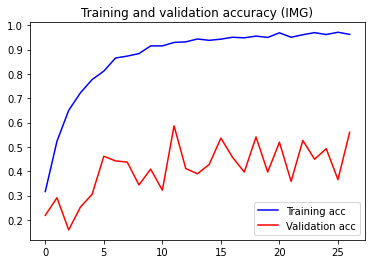

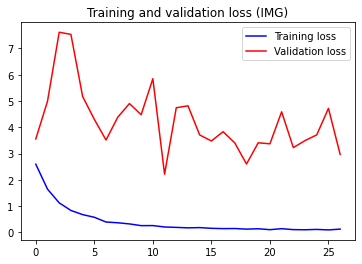

In [ ]:
'''PLOT CURVES'''

path = path_drive+'ProgettoDL/'

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
lista = [acc,val_acc,loss,val_loss]


#print(corr(history.history['accuracy'], history_mask.history_mask['accuracy']))

import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}.pdf'.format(immgs,cnn)))

In [ ]:
'''PLOT CURVES MASK'''

path = path_drive+'ProgettoDL/'

acc = history_mask.history['accuracy']
val_acc = history_mask.history['val_accuracy']
loss = history_mask.history['loss']
val_loss = history_mask.history['val_loss']
lista = [acc,val_acc,loss,val_loss]


#print(corr(history.history['accuracy'], history_mask.history_mask['accuracy']))

import csv

with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (MASK)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotAcc_{}_{}_MASK.pdf'.format(immgs,cnn))) 

plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (MASK)')
plt.legend()
plt.savefig(os.path.join(path+'weights/PlotLoss_{}_{}_MASK.pdf'.format(immgs,cnn)))

### SAVE MODEL 

In [ ]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model.save(os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn)))
print("Saved model to disk")

INFO:tensorflow:Assets written to: /content/drive/My Drive/ProgettoDL/weights/model_CALCIO_CROP_vgg16/Final/assets
Saved model to disk


In [ ]:
#salvataggio modello pesi finali
from tensorflow.keras.models import Sequential, save_model, load_model
path = path_drive+'ProgettoDL/'
model_mask.save(os.path.join(path+'weights/model_{}_{}_Mask/Final'.format(immgs,cnn)))
print("Saved model mask to disk")

## LOAD MODEL 

### LOAD MODEL (IMG) 

In [ ]:
'''TEST'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)

path_model = os.path.join(path+'weights/model_{}_{}/Final'.format(immgs,cnn))

model = load_model(path_model)
print('Model IMG Loaded')


Model IMG Loaded


### LOAD MODEL MASK 

In [ ]:
'''TEST'''
import os
from tensorflow.keras.models import Sequential, save_model, load_model
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

parte = 'CALCIO'
tipo = 'CROP' #CROP, CROP_gray_ridge
augment = True
metaclassi = False
cnn = "vgg16" #resnet50 

#classi = ['1','2','3','3+','4']
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']

immg_rows = 270 
immg_cols = 470
immgs = '{}_{}'.format(parte,tipo)

path_model_mask = os.path.join(path+'weights/model_{}_{}_Mask/Final'.format(immgs,cnn))

model_mask = load_model(path_model_mask)
print('Model Mask Loaded')

## PREDICTION 

### PREDICTION IMG CROP 

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model

test_array = []
test_array_series = []

for index, row in test.iterrows():
    class_ = int(row['class'])
    series_ = int(row['series'])          #---da qui e nei prossimi, calcolo la ground thruth del shotgun series, ovvero i semplici COD_COMPONENTE (serie) che appartengono al sub-set di test
    test_array.append(class_)
    test_array_series.append(series_)     #---

test_array = np.array(test_array)
test_array_series = np.array(test_array_series)   #---

y_test = to_categorical(np.unique(test_array, return_inverse=True)[1])
y_test_series = to_categorical(np.unique(test_array_series, return_inverse=True)[1])      #---

imgs_array = [] 


for index, row in testgen.df.iterrows():
    filename = row['filename']
    image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols))
    x = img_to_array(image)
    #x = preprocess_input(x)  #non dovrebbe servire
    imgs_array.append(x)
    X_test = np.asarray(imgs_array)


###PREDICTION MASK

In [ ]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras import Model

test_array2 = []

for index, row in test_mask.iterrows():
    class_ = int(row['class'])
    test_array2.append(class_)

test_array2 = np.array(test_array2)
print(test_array2)
y_test2 = to_categorical(np.unique(test_array2, return_inverse=True)[1])
imgs_array2 = []

for index, row in testgen_mask.df.iterrows():
    filename = row['mask_filename']
    image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols))
    x = img_to_array(image)
    #x = preprocess_input(x)  #non dovrebbe servire
    imgs_array2.append(x)
    X_test2 = np.asarray(imgs_array2)

## PREDICT CROP 

In [ ]:

y_test = y_test.argmax(axis=1)
y_test_series = y_test_series.argmax(axis=1)      #---
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)

print(y_pred.shape)
print(y_test.shape)



#y_pred_conf = model.predict(X_test)
#index = np.where(np.equal(y_pred, y_test) == False)[0]
#print(np.around(y_pred_conf[index], decimals = 2))

(424,)
(424,)


In [ ]:
print(y_test)
print(y_test_series)
print(y_pred)

[7 8 6 6 8 8 5 5 8 8 3 1 2 2 5 6 8 7 6 6 3 2 0 0 0 0 0 1 6 6 8 8 7 7 5 6 4
 4 8 8 6 6 5 5 6 6 8 8 8 8 5 4 5 5 5 5 1 1 6 6 0 1 4 4 5 5 9 9 6 7 9 9 2 0
 5 5 1 1 1 3 4 4 6 6 4 5 8 7 4 4 2 2 2 2 6 6 1 1 5 5 2 2 1 1 8 8 9 9 2 5 2
 2 6 6 3 3 3 3 5 5 2 2 2 3 5 5 2 1 4 4 5 5 2 1 3 3 2 2 6 6 4 4 0 5 8 8 4 4
 3 3 1 1 7 8 9 9 5 0 3 3 1 2 7 7 0 2 6 6 0 0 8 8 8 8 6 6 7 7 1 1 1 1 6 6 3
 3 5 5 4 4 5 5 4 4 3 3 2 2 7 8 4 4 8 8 1 2 6 6 6 6 5 5 8 7 6 6 6 6 2 3 3 3
 1 2 6 5 3 4 6 6 3 3 9 9 0 0 6 6 3 3 3 3 4 4 0 0 8 8 7 8 7 7 4 3 3 3 5 5 0
 0 6 6 1 0 6 6 9 8 7 7 5 5 8 8 6 7 3 3 5 5 4 5 5 5 6 6 1 0 9 8 5 5 7 7 6 6
 6 7 1 1 0 0 6 6 7 7 8 6 5 5 9 9 2 2 2 2 7 9 2 3 0 0 9 9 2 2 6 6 2 2 7 7 0
 0 8 7 0 0 5 5 0 0 1 2 1 0 3 3 3 3 8 7 5 5 3 3 8 8 5 4 1 2 4 4 4 4 9 9 4 4
 5 5 2 2 3 3 6 6 0 0 1 1 4 4 6 5 4 4 8 8 8 8 4 4 1 1 5 5 2 2 7 7 8 8 2 2 6
 5 6 6 8 8 5 5 6 6 6 6 8 9 3 3 9 9]
[ 4  4 12 12  4  4  2  2  4  4  7  7  1  1  0  0  4  4 12 12  9  9  3  3
  3  3  3  3  0  0  0  0  4  4  5  5  6  6  4  4 10 10  2  2  0  0

In [ ]:
#SEARCHING UNIVOQUE SERIES
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(y_test[i])
      pred_array_s0.append(y_pred[i])
    if series_ == 1:
      test_array_s1.append(y_test[i])
      pred_array_s1.append(y_pred[i])
    if series_ == 2:
      test_array_s2.append(y_test[i])
      pred_array_s2.append(y_pred[i])
    if series_ == 3:
      test_array_s3.append(y_test[i])
      pred_array_s3.append(y_pred[i])
    if series_ == 4:
      test_array_s4.append(y_test[i])
      pred_array_s4.append(y_pred[i])
    if series_ == 5:
      test_array_s5.append(y_test[i])
      pred_array_s5.append(y_pred[i])
    if series_ == 6:
      test_array_s6.append(y_test[i])
      pred_array_s6.append(y_pred[i])
    if series_ == 7:
      test_array_s7.append(y_test[i])
      pred_array_s7.append(y_pred[i])
    if series_ == 8:
      test_array_s8.append(y_test[i])
      pred_array_s8.append(y_pred[i])
    if series_ == 9:
      test_array_s9.append(y_test[i])
      pred_array_s9.append(y_pred[i])
    if series_ == 10:
      test_array_s10.append(y_test[i])
      pred_array_s10.append(y_pred[i])
    if series_ == 11:
      test_array_s11.append(y_test[i])
      pred_array_s11.append(y_pred[i])
    if series_ == 12:
      test_array_s12.append(y_test[i])
      pred_array_s12.append(y_pred[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

[5, 6, 6, 6, 8, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 5, 5, 6, 6, 6, 6]
[6, 4, 9, 9, 9, 9, 8, 8, 8, 9, 8, 8, 6, 8, 9, 9, 9, 8, 9, 8, 9, 8, 8, 9]
[4 5 6 7 8 9]


##PREDICT MASK

In [ ]:
y_test2 = y_test2.argmax(axis=1)
y_pred2 = model_mask.predict(X_test2)
y_pred2 = np.argmax(y_pred2,axis=1)

print(y_pred2.shape)
print(y_test2.shape)

## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')

a = accuracy_score(y_test, y_pred)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy:",a)
print("precision:", precision_score(y_test, y_pred , average="macro"))          # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall:", recall_score(y_test, y_pred , average="macro"))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score:", f1_score(y_test, y_pred , average="macro"))                  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score

print('classification report:')
print(classification_report(y_test, y_pred))  



--------------Metrice IMG----------------
test accuracy: 0.23349056603773585
precision: 0.3122679763610759
recall: 0.25274820564195394
f1_score: 0.19535287732422107
classification report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        33
           1       0.23      0.18      0.20        34
           2       0.00      0.00      0.00        44
           3       0.44      0.25      0.32        44
           4       0.32      0.38      0.34        40
           5       0.41      0.12      0.18        60
           6       0.19      0.24      0.21        67
           7       0.12      0.03      0.05        31
           8       0.26      0.49      0.34        49
           9       0.15      0.82      0.25        22

    accuracy                           0.23       424
   macro avg       0.31      0.25      0.20       424
weighted avg       0.31      0.23      0.20       424



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

print('--------------Metrice Mask----------------')

'''METRICHE'''

a = accuracy_score(y_test2, y_pred2)                                              # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
print("test accuracy:",a)
print("precision:", precision_score(y_test2, y_pred2 , average="macro"))          # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("recall:", recall_score(y_test2, y_pred2 , average="macro"))                # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score
print("f1_score:", f1_score(y_test2, y_pred2 , average="macro"))                  # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score

print('classification report:')
print(classification_report(y_test2, y_pred2))  

## PLOT CONFUSION MATRIX FUNCTION 

In [ ]:
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX 

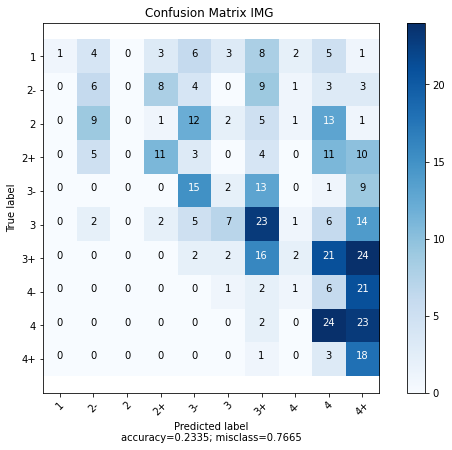

<Figure size 432x288 with 0 Axes>

In [ ]:
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
fig = plot_confusion_matrix(cm,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix IMG ")
plt.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(immgs,cnn))) 




##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

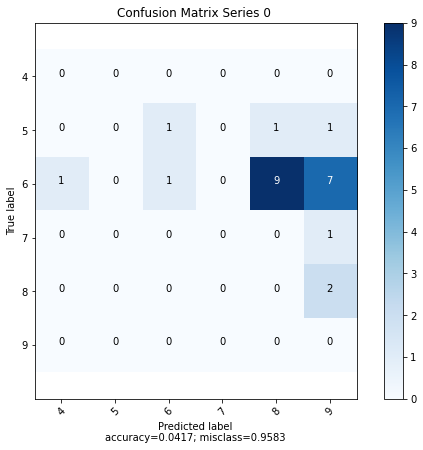

<Figure size 432x288 with 0 Axes>

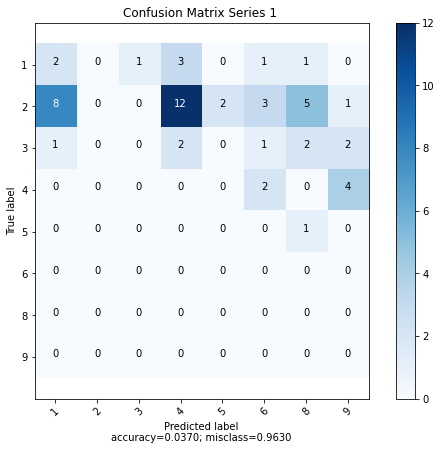

<Figure size 432x288 with 0 Axes>

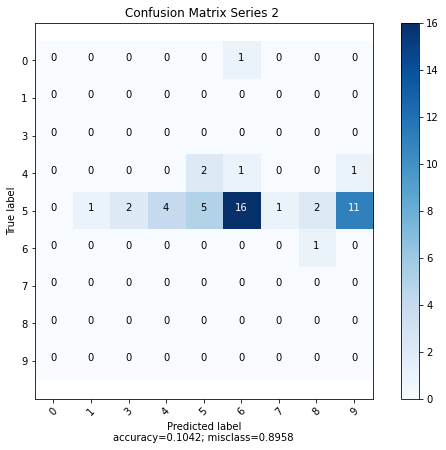

<Figure size 432x288 with 0 Axes>

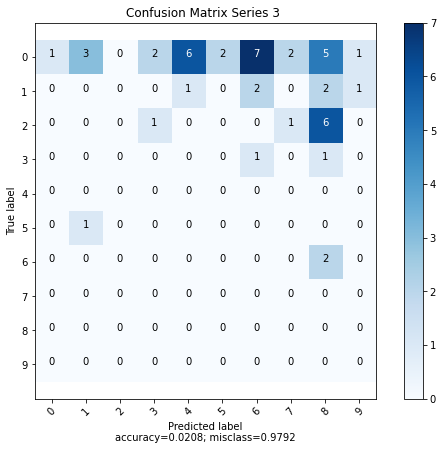

<Figure size 432x288 with 0 Axes>

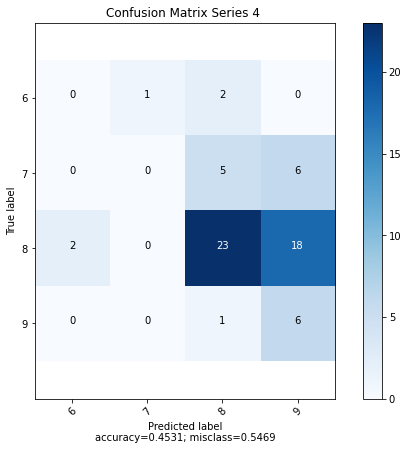

<Figure size 432x288 with 0 Axes>

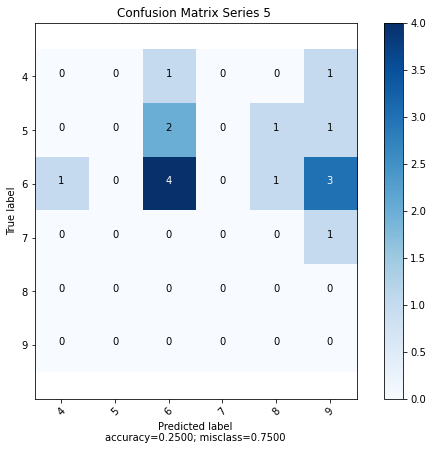

<Figure size 432x288 with 0 Axes>

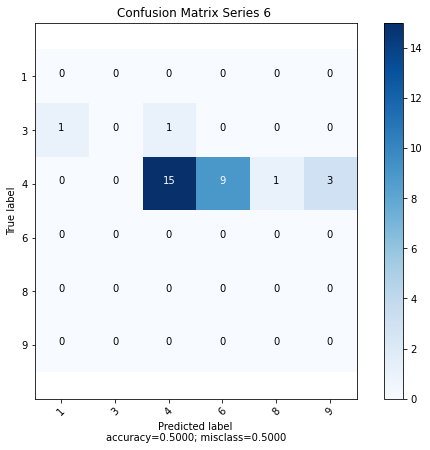

<Figure size 432x288 with 0 Axes>

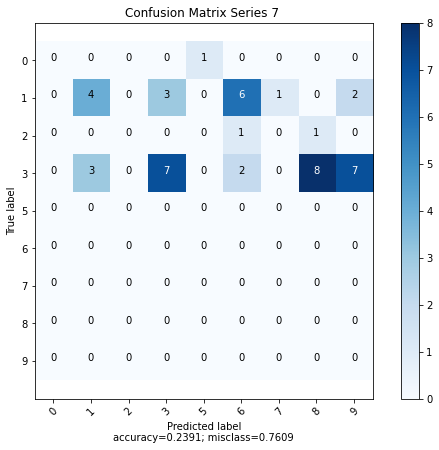

<Figure size 432x288 with 0 Axes>

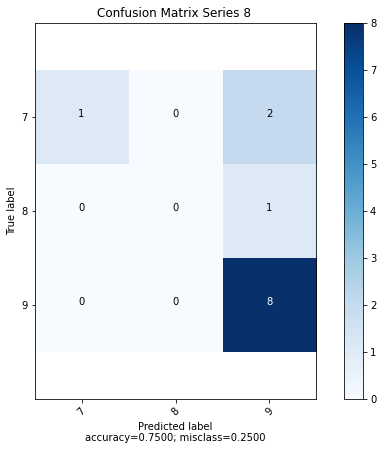

<Figure size 432x288 with 0 Axes>

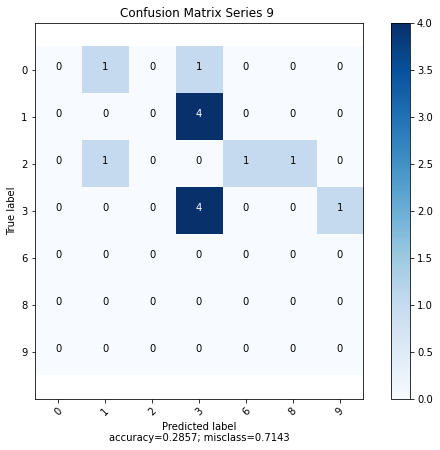

<Figure size 432x288 with 0 Axes>

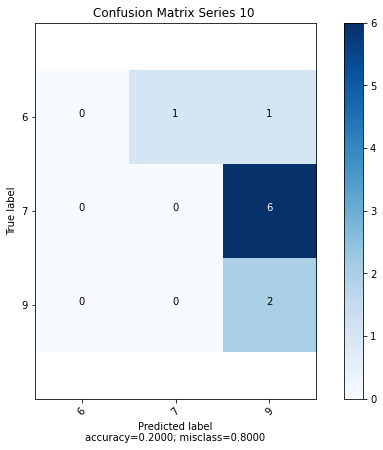

<Figure size 432x288 with 0 Axes>

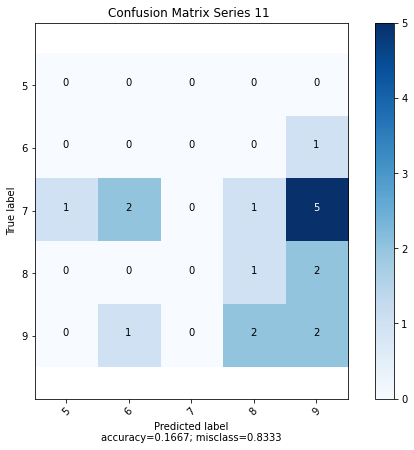

<Figure size 432x288 with 0 Axes>

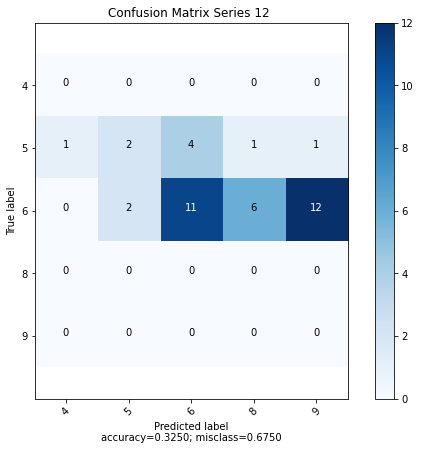

<Figure size 432x288 with 0 Axes>

In [ ]:
import sklearn.metrics as metrics
from functools import reduce
#serie 0
cm0 = metrics.confusion_matrix(y_true=test_array_s0, y_pred=pred_array_s0)
fig = plot_confusion_matrix(cm0,
                      target_names = reduce(np.union1d, (pred_array_s0, test_array_s0)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 0 ")
plt.savefig(os.path.join(path+'weights/CM_serie0_{}_{}.pdf'.format(immgs,cnn))) 

#serie 1
cm1 = metrics.confusion_matrix(y_true=test_array_s1, y_pred=pred_array_s1)
fig = plot_confusion_matrix(cm1,
                      target_names = reduce(np.union1d, (pred_array_s1, test_array_s1)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 1 ")
plt.savefig(os.path.join(path+'weights/CM_serie1_{}_{}.pdf'.format(immgs,cnn))) 

#serie 2
cm2 = metrics.confusion_matrix(y_true=test_array_s2, y_pred=pred_array_s2)
fig = plot_confusion_matrix(cm2,
                      target_names = reduce(np.union1d, (pred_array_s2, test_array_s2)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 2 ")
plt.savefig(os.path.join(path+'weights/CM_serie2_{}_{}.pdf'.format(immgs,cnn))) 

#serie 3
cm3 = metrics.confusion_matrix(y_true=test_array_s3, y_pred=pred_array_s3)
fig = plot_confusion_matrix(cm3,
                      target_names = reduce(np.union1d, (pred_array_s3, test_array_s3)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 3 ")
plt.savefig(os.path.join(path+'weights/CM_serie3_{}_{}.pdf'.format(immgs,cnn))) 

#serie 4
cm4 = metrics.confusion_matrix(y_true=test_array_s4, y_pred=pred_array_s4)
fig = plot_confusion_matrix(cm4,
                      target_names = reduce(np.union1d, (pred_array_s4, test_array_s4)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 4 ")
plt.savefig(os.path.join(path+'weights/CM_serie4_{}_{}.pdf'.format(immgs,cnn))) 

#serie 5
cm5 = metrics.confusion_matrix(y_true=test_array_s5, y_pred=pred_array_s5)
fig = plot_confusion_matrix(cm5,
                      target_names = reduce(np.union1d, (pred_array_s5, test_array_s5)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 5 ")
plt.savefig(os.path.join(path+'weights/CM_serie5_{}_{}.pdf'.format(immgs,cnn))) 

#serie 6
cm6 = metrics.confusion_matrix(y_true=test_array_s6, y_pred=pred_array_s6)
fig = plot_confusion_matrix(cm6,
                      target_names = reduce(np.union1d, (pred_array_s6, test_array_s6)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 6 ")
plt.savefig(os.path.join(path+'weights/CM_serie6_{}_{}.pdf'.format(immgs,cnn))) 

#serie 7
cm7 = metrics.confusion_matrix(y_true=test_array_s7, y_pred=pred_array_s7)
fig = plot_confusion_matrix(cm7,
                      target_names = reduce(np.union1d, (pred_array_s7, test_array_s7)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 7 ")
plt.savefig(os.path.join(path+'weights/CM_serie7_{}_{}.pdf'.format(immgs,cnn))) 

#serie 8
cm8 = metrics.confusion_matrix(y_true=test_array_s8, y_pred=pred_array_s8)
fig = plot_confusion_matrix(cm8,
                      target_names = reduce(np.union1d, (pred_array_s8, test_array_s8)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 8 ")
plt.savefig(os.path.join(path+'weights/CM_serie8_{}_{}.pdf'.format(immgs,cnn))) 

#serie 9 
cm9 = metrics.confusion_matrix(y_true=test_array_s9, y_pred=pred_array_s9)
fig = plot_confusion_matrix(cm9,
                      target_names = reduce(np.union1d, (pred_array_s9, test_array_s9)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 9 ")
plt.savefig(os.path.join(path+'weights/CM_serie9_{}_{}.pdf'.format(immgs,cnn))) 

#serie 10
cm10 = metrics.confusion_matrix(y_true=test_array_s10, y_pred=pred_array_s10)
fig = plot_confusion_matrix(cm10,
                      target_names = reduce(np.union1d, (pred_array_s10, test_array_s10)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 10 ")
plt.savefig(os.path.join(path+'weights/CM_serie10_{}_{}.pdf'.format(immgs,cnn))) 

#serie 11
cm11 = metrics.confusion_matrix(y_true=test_array_s11, y_pred=pred_array_s11)
fig = plot_confusion_matrix(cm11,
                      target_names = reduce(np.union1d, (pred_array_s11, test_array_s11)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 11 ")
plt.savefig(os.path.join(path+'weights/CM_serie11_{}_{}.pdf'.format(immgs,cnn))) 

#serie 12
cm12 = metrics.confusion_matrix(y_true=test_array_s12, y_pred=pred_array_s12)
fig = plot_confusion_matrix(cm12,
                      target_names = reduce(np.union1d, (pred_array_s12, test_array_s12)),
                      normalize    = False,
                      title        = "Confusion Matrix Series 12 ")
plt.savefig(os.path.join(path+'weights/CM_serie12_{}_{}.pdf'.format(immgs,cnn))) 

##PLOT CONFUSION MATRIX PER MASK IMAGES

In [ ]:
import sklearn.metrics as metrics
cm_mask = metrics.confusion_matrix(y_true=y_test2, y_pred=y_pred2)
fig = plot_confusion_matrix(cm_mask,
                      target_names = classi,
                      normalize    = False,
                      title        = "Confusion Matrix MASK ")
plt.savefig(os.path.join(path+'weights/CM_{}_{}_MASK.pdf'.format(immgs,cnn))) 

## CRAMER V CORRELATION

In [ ]:
#PRIMA VERSIONE
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(y_test, y_pred)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print(cramer1)

confusion_matrix2 = pd.crosstab(y_test_series, y_pred)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)

cramer correlation tra predizioni delle classi, e le classi effettive
0.2748929546507809
cramer correlation tra predizioni delle classi e le ground thruth di shotgun series
0.3221705294498035


In [ ]:
#SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo
contTable = pd.crosstab(y_test_series, y_pred)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(y_pred), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))


col_0  0   1   3   4  5   6  7   8   9
row_0                                 
0      0   0   0   1  0   2  0  10  11
1      0  11   1  17  2   7  0   9   7
2      0   1   2   4  7  18  1   3  12
3      1   4   3   7  2  10  3  16   2
4      0   0   0   0  0   2  1  31  30
5      0   0   0   1  0   7  0   2   6
6      0   1   0  16  0   9  0   1   3
7      0   7  10   0  1   9  1   9   9
8      0   0   0   0  0   0  1   0  11
9      0   2   9   0  0   1  0   1   1
10     0   0   0   0  0   0  1   0   9
11     0   0   0   0  1   3  0   4  10
12     0   0   0   1  4  15  0   7  13

                 Chi-square test   results
0  Pearson Chi-square ( 96.0) =   441.6372
1                     p-value =     0.0000
2                  Cramer's V =     0.3608

df = 8
V = 0.3608

quality classification of the correlation is:   large


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

# T-SNE  & PCA


## Spiegazioni e Link Utili

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


## IMG TO GRAY SCALE - GIA' FATTO

In [ ]:
#i = 0 
#for index, row in result.iterrows():
    #print(i)
    #i+=1
#    filename = row['filename']
#    gray_scale(filename)

## DATASET COMPLETO GRAY_MASK_IMG_CROP

In [ ]:
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx_complessivo.columns = ['ID','series', 'filename', 'class']
dataframe_dx_complessivo.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx_complessivo, dataframe_dx_complessivo]
result_complessivo = pd.concat(frames)
#print(result_complessivo)
#print(result_complessivo.loc[[1]])
#print(type(result_complessivo.loc[[1]]))

result_complessivo["class"] = result_complessivo["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result_complessivo["series"] = result_complessivo["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))
print(result_complessivo.loc[result_complessivo['class'] == '0'])
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo['class'] = pd.to_numeric(result_complessivo['class'], errors='coerce')
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo = result_complessivo.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result_complessivo[result_complessivo['class'].isnull()])

print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_CROP')
for index, row in result_complessivo.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result_complessivo = result_complessivo.drop(result_complessivo[(result_complessivo['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))

print('------------------- DATASET BASE ---------------')
print(type(result_complessivo))  
print(len(result_complessivo))
print(result_complessivo)

result_complessivo_totale = pd.DataFrame()

for index, row in result_complessivo.iterrows():
  filename_mask = 'mask_{}'.format(row['filename'])
  filename_gray = 'gray_{}'.format(row['filename'])
  class_ = row['class']
  series_ = row['series']
  #print('{}_{}_{}_{}'.format(filename_gray,filename_mask, class_, series_)) "ID": row['ID']
  row_df_1 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_mask, "class" : class_},index=[0])
  row_df_2 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_gray, "class" : class_},index=[0])
  row_df_3 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #print(row_df_1)
  #print(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_1)
  result_complessivo_totale = result_complessivo_totale.append(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_3)


print('------------------- DATASET COMPLESSIVO ---------------') 
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
#print(result_complessivo_totale)

from sklearn.utils import shuffle
result_complessivo_totale = shuffle(result_complessivo_totale)
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
print(result_complessivo_totale)


Null VALUE di class : 2
Empty DataFrame
Columns: [ID, series, filename, class]
Index: []
       ID  series            filename  class
963  1927       3  20200825181909.png    NaN
963  1927       3  20200825181932.png    NaN
       ID  series            filename  class
963  1927       3  20200825181909.png    NaN
963  1927       3  20200825181932.png    NaN
Empty DataFrame
Columns: [ID, series, filename, class]
Index: []
Null VALUE di class : 0
File : 20202 13101023.png eliminato
File : 20200825180901.png eliminato
File : 20200825181058.png eliminato
File : 20202 13101011.png eliminato
File : 20200825180918.png eliminato
------------------- DATASET BASE ---------------
<class 'pandas.core.frame.DataFrame'>
2120
        ID  series            filename  class
0        3       0  20201 319 5323.png    6.0
1        4       0  20201 3110125 .png    6.0
2        5       0  20201 31101327.png    6.0
3        6       0  20201 3110161 .png    6.0
4        7       0  20201 3110177 .png    6.0
... 

## IMPORT -- PER IL TSNE e il PLOT RELATIVO

In [ ]:
%matplotlib inline
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd    
from sklearn.preprocessing import StandardScaler


## IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini

In [ ]:
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


from tqdm import tqdm

immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []
data_X = result_complessivo_totale['filename'][:1000]

result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim

y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... 

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    
    #print(image)
    #print('Originale : {} x {} x {}'.format(image.size[0], image.size[1], len(image.size)-1))
    #plt.imshow(image)
    scale_percent = 90 # percent of original size
    width, height = image.size
    #print('channel : {}'.format(len(image.size)))
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X = np.asarray(imgs_array_tot)
print(X.shape)
    



1000it [03:20,  4.98it/s]

(1000, 243, 423)


## Check & Create Dataframe for PCA (Principal Analysis Component) & T-SNE (t-distributed stochastic neighbor embedding)

In [ ]:
print('X SHAPE : {}'.format(X.shape))

nsamples = X.shape[0]
rows = X.shape[1]
cols = X.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X))
X_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente 
#print(X_1)

feat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df = pd.DataFrame(X_1,columns=feat_cols)
#df = pd.DataFrame(X_1)
df['y'] = pd.DataFrame({ 'y': np.array(y) })
df['label'] = df['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))



# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])






X SHAPE : (1000, 243, 423)
n_samples : 1000 , rows : 243 , cols : 423 , channel : 1 
<class 'numpy.ndarray'>
X MODIFICATO : (1000, 102789)
Feat Cols : 102789 
Size of the dataframe: (1000, 102791)


## First Analysis Component whit 3 Component 

In [ ]:
#pca = PCA(n_components=3)
#pca_result = pca.fit_transform(X_1)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.67109054 0.14714858 0.04064544]


## Plot the PCA 2D and 3D

[3. 1. 2. 8. 0. 6. 7. 5. 9. 4.]


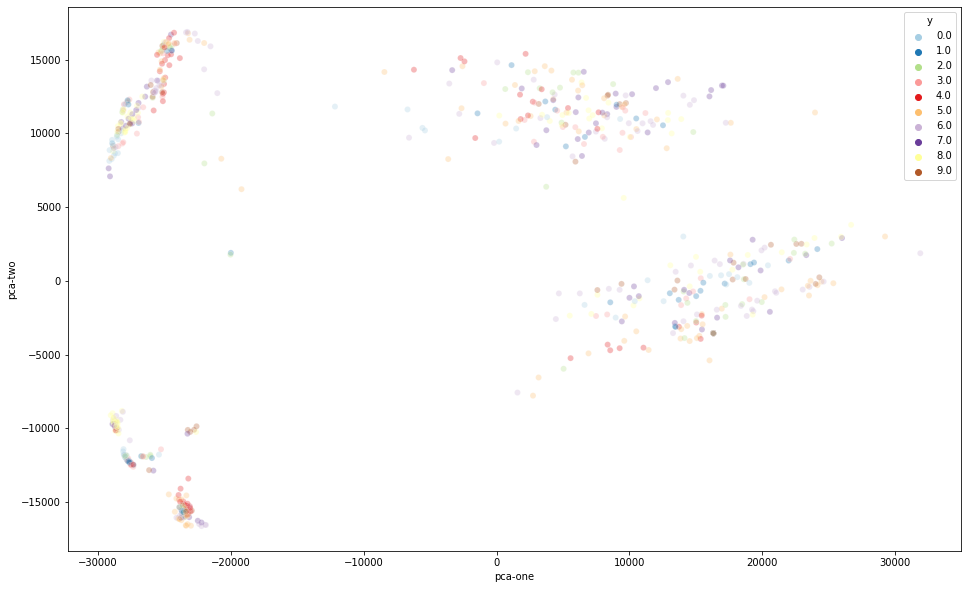

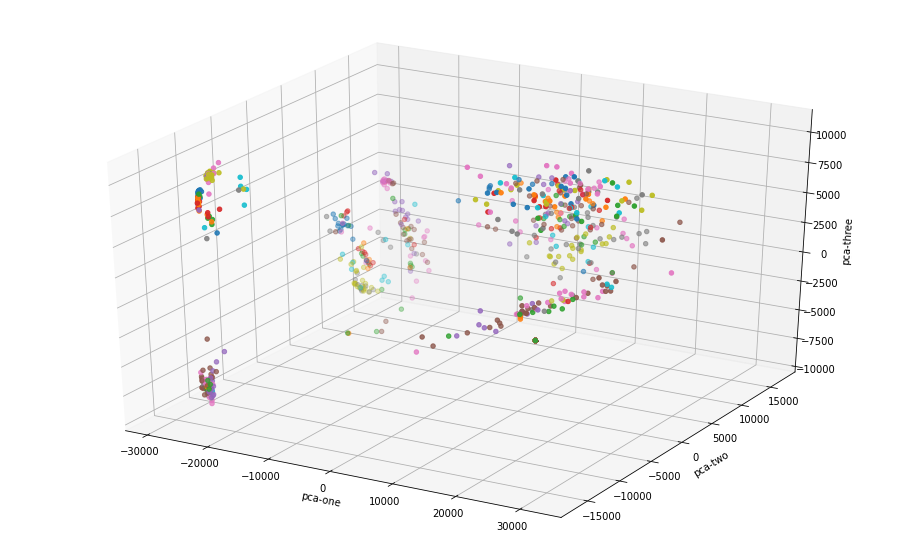

In [ ]:
print(df['y'].unique()) #-- controllo se vanno bene le label 
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

#plot in 3d
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [ ]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset) #-- Manda in crisi la ram 
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.72203557 0.1583192  0.04373102]


## Calcolo TSNE & PLOT TSNE

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 10.447s...
[t-SNE] Computed neighbors for 1000 samples in 10.544s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.543812
[t-SNE] KL divergence after 2000 iterations: 0.184052
t-SNE done! Time elapsed: 33.689444065093994 seconds


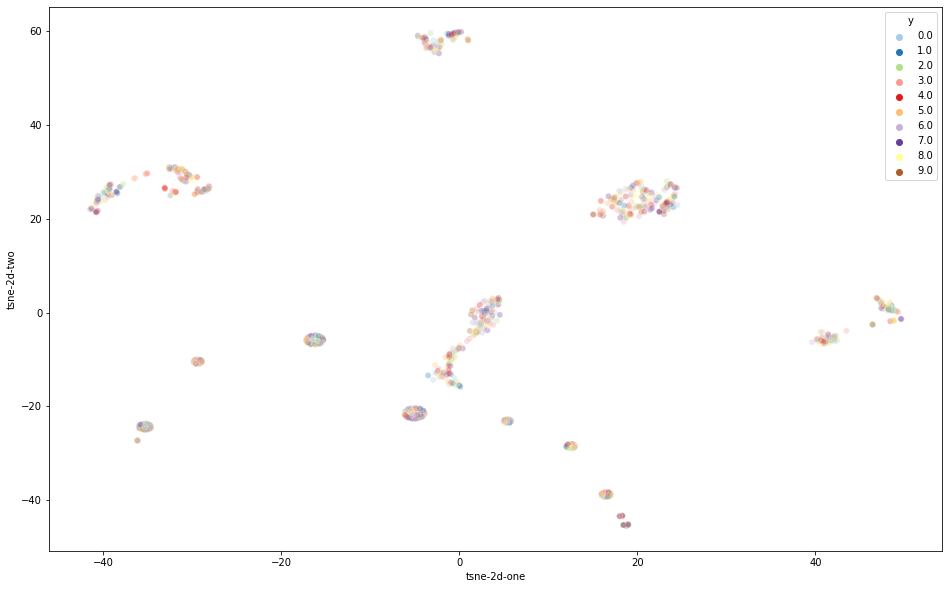

In [27]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)

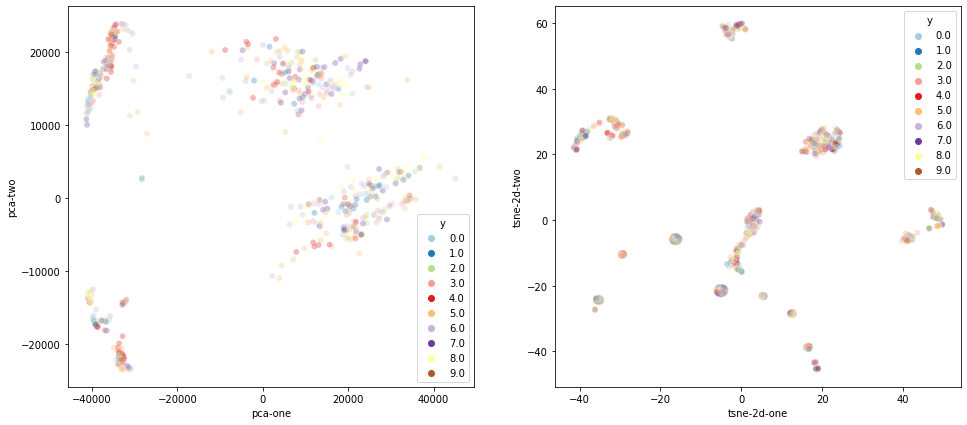

In [28]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

## Altre funzioni ... "Mischio le carte in tavola"

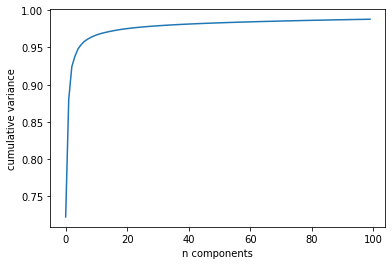

In [29]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(df)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

The ***KL divergence*** is a measure of how different one probability distribution from a second.

t-SNE - KL divergence after 250 iterations with early exaggeration: 45.508762

t-SNE - KL divergence after 2600 iterations: 0.195492


In [33]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_results = tsne.fit_transform(df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 11.270s...
[t-SNE] Computed neighbors for 1000 samples in 10.938s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.508762
[t-SNE] KL divergence after 2600 iterations: 0.195492
t-SNE done! Time elapsed: 36.93963265419006 seconds


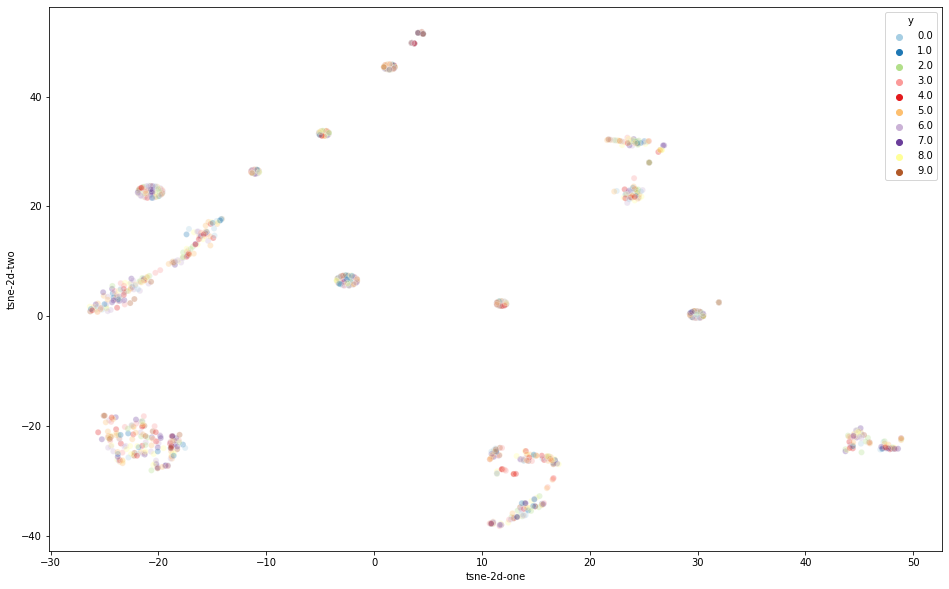

In [31]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)

## Aumento le fee da analizzare 

[Link Utile](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)

In [34]:
time_start = time.time()
pca_50 = PCA(n_components=200)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))
print('Time elapsed: {} seconds'.format(time.time()-time_start))

Cumulative explained variation for 50 principal components: 0.9951933724257488
Time elapsed: 18.945103883743286 seconds
